# Domain Generating Algorithms - Model / Feature Selection

Now that we've explored the data and developed a pipeline for generating features, let's identifying which type of classification model is up to the task.

There are a couple of considerations:
* Scoring, how well does the model generalise to data it was not trained particularly given the imbalanced nature of the data
* Complexity, is the model one that we can explain to people who may not have an understanding of model development but may be held accountable for the decisions made by the model.
* Time, how long does it take for the model to be fit

Depending on the siutation we can make different trade-offs on the above. I am assuming that priorities are in the order that they listed.

In [1]:
import os
from time import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Change our working directory so our project src import will work.

In [2]:
os.chdir("../")

In [3]:
! ls data

external
interim
processed
raw


Yes we are let's import the function we need to prepare our data.

## Reading in and Preprocessing Data

In [4]:
from src.preprocessing import NormaliseTextColumnsTransformer

In [5]:
input_df = pd.read_csv("data/raw/dga_domains.csv")

In [6]:
preprocess_pipeline = Pipeline([
    (
        "preprocess",
        NormaliseTextColumnsTransformer("normed", ["domain"])
    )
])

In [7]:
preprocess_out = preprocess_pipeline.transform(input_df)

In [8]:
df = pd.DataFrame(preprocess_out, columns = preprocess_pipeline["preprocess"].get_feature_names())

In [9]:
df.head()

,host,class,subclass,domain_normed
0,000directory.com.ar,legit,legit,000directory
1,000webhost.com,legit,legit,000webhost
2,001fans.com,legit,legit,001fans
3,01-telecharger.com,legit,legit,01-telecharger
4,010shangpu.com,legit,legit,010shangpu


In [10]:
df = df[["class", "domain_normed"]]

In [11]:
len(df)

133926

In [12]:
df = df.dropna()

In [13]:
len(df)

133926

In [14]:
df = df.drop_duplicates()

In [15]:
len(df)

114525

In [16]:
df.sample(10, random_state = 6)

,class,domain_normed
132340,dga,yravkfemaujp
111813,legit,thedailystar
133702,dga,zopguydozeumvnbayzdgadgypvx
24819,legit,chronofhorse
62273,legit,joydownload
96165,legit,rain-mail
4,legit,010shangpu
104774,legit,skyworth
12691,legit,apnicommunity
128368,dga,xctcyhlcqeapdmadcynrtt


We've previously limited the scope of the effort to only consider the `domain` and the `class` attrbiute.

In [17]:
X = df[["domain_normed"]]
y = df["class"]

In [18]:
from src.features.transformer import CharacterCountTransformer
from src.features.transformer import CharacterVarietyRatioTransformer
from src.features.transformer import CharacterDistanceLeftRightTransformer
from src.features.transformer import CharacterRatioTransformer
from src.features.transformer import BinarizeCharacterPairsTransformer
from src.features.transformer import CountCharacterPairsTransformer
from src.features.transformer import TextLengthTransformer

In [19]:
from src.features import mode

Let's construct a Pipeline for generating some features we are interested in based on the EDA.

In [20]:
column = "domain_normed"

generate_features = FeatureUnion([
    (
        "digit_ratio", 
        CharacterRatioTransformer(
            "digit_ratio", [column], 
            [x for x in "1234567890"]
        )
    ),
    (
        "vowel_ratio", 
        CharacterRatioTransformer(
            "vowel_ratio", [column], 
            [x for x in "aeiouy"]
        )
    ),
    (
        "vowel_distance_std_ratio",
        CharacterDistanceLeftRightTransformer(
            "vowel_distance_std_ratio", [column], 
            [x for x in "aeiouy"], np.std, 
            True
        )
    ),
    (
        "vowel_distance_mode_ratio",
        CharacterDistanceLeftRightTransformer(
            "vowel_distance_mode_ratio", [column], 
            [x for x in "aeiouy"], mode, 
            True
        )
    ),
    (
        "consonants_variety_ratio",
        CharacterVarietyRatioTransformer(
            "consonants_variety_ratio", [column],
            [x for x in "aeiouy"]
        )
    ),
    (
        "len",
        TextLengthTransformer(
            "len", [column],
        )
    )
])

In [21]:
pipeline = Pipeline([
    (
        "generate_features",
        generate_features
    ) 
])

In [22]:
eda_X = pipeline.transform(X)

In [23]:
eda_X[0:1]

array([[ 0.25      ,  0.33      ,  0.10276839,  0.        ,  0.38      ,
        12.        ]])

Let's get our new column names

In [24]:
generated_feature_names = pipeline['generate_features'].get_feature_names()
generated_feature_names

['digit_ratio__domain_normed_digit_ratio',
 'vowel_ratio__domain_normed_vowel_ratio',
 'vowel_distance_std_ratio__domain_normed_vowel_distance_std_ratio',
 'vowel_distance_mode_ratio__domain_normed_vowel_distance_mode_ratio',
 'consonants_variety_ratio__domain_normed_consonants_variety_ratio',
 'len__domain_normed_len']

## Character Pair Counts and Binarised Appereances

We were also interested the character pair windows, This could be encoded as binary (was a character pair present) or as a count (how many times did the character appear).

However given that these will be very sparse, let's validate if there is any explanatory power to had in including only a subset of these columns by using Principal Componenet Analysis.

In EDA the top 20 character pairs for `legit` records were identified.

In [25]:
top_20_legit_pairs  = ['in','er','re','an','es','ar','on', 'or', 'st', 'ne', 'te', 'li', 'al', 'ra',
 'en', 'ma', 'me', 'to', 'ti', 'le']

However lets see if we can identify other pairs with explanatory power using PCA.

In [26]:
bin_pairs = BinarizeCharacterPairsTransformer("bin_pair", ["domain_normed"])
bin_pca = PCA()

bin_pipeline = Pipeline([
    (
        "bin_pair", 
        bin_pairs
    ),
    (
        "standard_scaler",
        StandardScaler()
    ),
    (
        "pca",
        bin_pca,
    )
])

In [27]:
bin_X = bin_pipeline.fit_transform(X)

Let's plot cumulative sum of explained variance as determined by PCA.

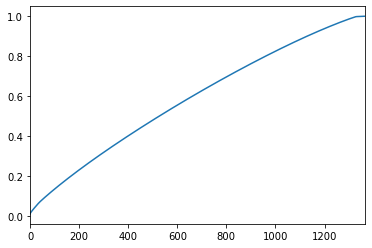

In [28]:
pd.Series(bin_pipeline['pca'].explained_variance_ratio_.cumsum()).plot()

It appears that isn't a point as we increase the number of variables (our character pairs) drasticially increases the explained variance. Thus complexity and performance trade off in adding in additional variables, isn't looking too favourably.

Having said that let's look at the difference in the cumulative explained variance.

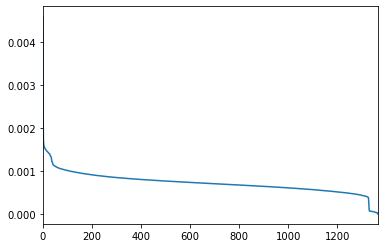

In [29]:
pd.Series(np.diff(bin_pipeline['pca'].explained_variance_ratio_.cumsum())).plot()

Let's focus on the begining of the line where the greatest differences in cumulative explained ratio reside,

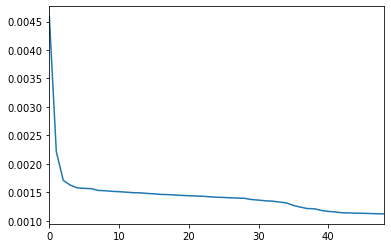

In [30]:
pd.Series(np.diff(bin_pipeline['pca'].explained_variance_ratio_.cumsum()[:50])).plot()

It would seem around 35 pairs the cumulative increase between steps starts to platuea. Like we did in our eda lets consider the top 20 from our PCA analysis. 

In [31]:
def get_pca_important_feature_per_component(pca, feature_names):
    # as per https://stackoverflow.com/a/56722874/2805700
    # number of components
    n_pcs= pca.components_.shape[0]

    # get the index of the most important feature on EACH component i.e. largest absolute value
    # using LIST COMPREHENSION HERE
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = feature_names

    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

    # using LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    return pd.DataFrame(sorted(dic.items()))

In [32]:
get_pca_important_feature_per_component(
    bin_pipeline['pca'],
    bin_pipeline['bin_pair'].get_feature_names()
)[1].value_counts()[:20]

domain_normed_bin_pair_--    9
domain_normed_bin_pair_or    8
domain_normed_bin_pair_2-    8
domain_normed_bin_pair_9-    8
domain_normed_bin_pair_-1    8
domain_normed_bin_pair_36    7
domain_normed_bin_pair_e-    7
domain_normed_bin_pair_on    7
domain_normed_bin_pair_ff    6
domain_normed_bin_pair_yw    6
domain_normed_bin_pair_j-    6
domain_normed_bin_pair_fe    6
domain_normed_bin_pair_ve    6
domain_normed_bin_pair_ws    6
domain_normed_bin_pair_ee    6
domain_normed_bin_pair_xx    5
domain_normed_bin_pair_ss    5
domain_normed_bin_pair_ct    5
domain_normed_bin_pair_dt    5
domain_normed_bin_pair_zl    5
Name: 1, dtype: int64

Very different seat of pairs as determined by PCA, compared to our EDA. How much variance do these variables explain?

In [33]:
bin_pipeline['pca'].explained_variance_ratio_.cumsum()[:20]

array([0.00960384, 0.01419793, 0.01641204, 0.01812022, 0.0197454 ,
       0.021323  , 0.02289102, 0.0244544 , 0.02598596, 0.02751267,
       0.02902835, 0.03053819, 0.03203986, 0.03353207, 0.03502186,
       0.03650117, 0.0379731 , 0.0394346 , 0.04089305, 0.0423447 ])

~ 4.2% of the dataset variance.

Now lets calculate the same for the counts.

In [34]:
count_pairs = CountCharacterPairsTransformer(
    "count_pair", ["domain_normed"],
)
count_pca = PCA()

count_pipeline = Pipeline([
    (
        "count_pair", 
        count_pairs,
    ),
    (
        "standard_scaler",
        StandardScaler()
    ),    
    (
        "pca",
        count_pca,
    )
])

In [35]:
count_X = count_pipeline.fit_transform(X)

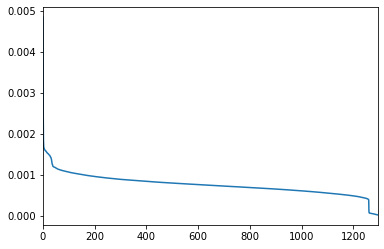

In [36]:
pd.Series(np.diff(count_pipeline['pca'].explained_variance_ratio_.cumsum())).plot()

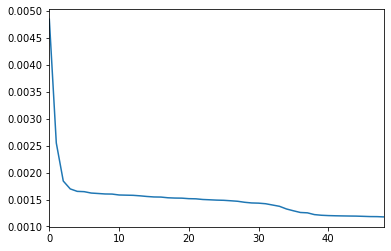

In [37]:
pd.Series(np.diff(count_pipeline['pca'].explained_variance_ratio_.cumsum()[:50])).plot()

Now let's compare the explainable variance between bins and counts.

In [38]:
count_pipeline['pca'].explained_variance_ratio_.cumsum()[:20]

array([0.01011302, 0.01496249, 0.0175134 , 0.0193576 , 0.02105553,
       0.02270803, 0.02435471, 0.02597587, 0.02758862, 0.02919265,
       0.03079464, 0.03237973, 0.03396163, 0.03554053, 0.03711008,
       0.03866747, 0.04021594, 0.04176239, 0.04329578, 0.04482392])

~ 4.4% of the dataset variance. Lets see which pairs they were.

In [39]:
count_pca_feature_importance = get_pca_important_feature_per_component(
    count_pipeline['pca'],
    count_pipeline['count_pair'].get_feature_names()
)[1].value_counts()

print(count_pca_feature_importance[:20])

domain_normed_count_pair_we    9
domain_normed_count_pair_ff    7
domain_normed_count_pair_di    7
domain_normed_count_pair_jj    6
domain_normed_count_pair_oo    6
domain_normed_count_pair_ga    6
domain_normed_count_pair_36    6
domain_normed_count_pair_re    6
domain_normed_count_pair_qq    6
domain_normed_count_pair_or    6
domain_normed_count_pair_vv    5
domain_normed_count_pair_ve    5
domain_normed_count_pair_he    5
domain_normed_count_pair_ct    5
domain_normed_count_pair_gg    5
domain_normed_count_pair_ne    5
domain_normed_count_pair_pv    5
domain_normed_count_pair_12    5
domain_normed_count_pair_wc    5
domain_normed_count_pair_ss    5
Name: 1, dtype: int64


Given the nominal increase using counts rather than the binary approach, lets go forward with the counts.

Let's extract the pairs identifed by PCA removing any that already appear in the `top_20_legit_pairs`.

In [40]:
pca_pairs = [x.replace("domain_normed_count_pair_", "") for x in  count_pca_feature_importance.index[0:20]]
print(pca_pairs)
pca_pairs = [x for x in pca_pairs if x not in top_20_legit_pairs] 
print(pca_pairs)

['we', 'ff', 'di', 'jj', 'oo', 'ga', '36', 're', 'qq', 'or', 'vv', 've', 'he', 'ct', 'gg', 'ne', 'pv', '12', 'wc', 'ss']
['we', 'ff', 'di', 'jj', 'oo', 'ga', '36', 'qq', 'vv', 've', 'he', 'ct', 'gg', 'pv', '12', 'wc', 'ss']


We could consider these pairs in addition to the ones we've previously identified.

# Feature Generation Pipeline


In [41]:
combined_features = FeatureUnion([
    (
        "generate_features",
        generate_features
    ),
    (
        "count_pairs_legit",
        CountCharacterPairsTransformer(
            "count_pair", ["domain_normed"], top_20_legit_pairs
        )
    ),
    (
        "count_pairs_pca",
        CountCharacterPairsTransformer(
            "count_pair", ["domain_normed"], pca_pairs
        )        
    )
])

Once again let's apply PCA to identify the features that have explanatory power.

In [42]:
combined_pipeline = Pipeline([
    (
        "combined_features",
        combined_features
    ),
    (
        "standard_scaler",
        StandardScaler()
    ),
])

In [43]:
combined_X = combined_pipeline.fit_transform(X)

In [44]:
combined_features_names = combined_pipeline["combined_features"].get_feature_names()

In [45]:
combined_pca_pipeline = Pipeline([
    (
        "combined_pipeline",
        combined_pipeline
    ),
    (
        "pca",
        PCA(),
    )
])

In [46]:
combined_pca_X = combined_pca_pipeline.fit_transform(X)

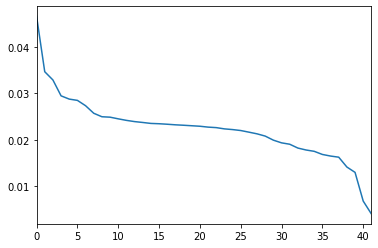

In [47]:
pd.Series(np.diff(combined_pca_pipeline['pca'].explained_variance_ratio_.cumsum())).plot()

Let's have a look at the importance of our combined features.

In [48]:
combined_pca_feature_importance = get_pca_important_feature_per_component(
    combined_pca_pipeline['pca'],
    combined_features_names,
)[1].value_counts()

print(combined_pca_feature_importance)

count_pairs_pca__domain_normed_count_pair_pv                                             3
count_pairs_legit__domain_normed_count_pair_to                                           2
count_pairs_pca__domain_normed_count_pair_qq                                             2
count_pairs_pca__domain_normed_count_pair_ga                                             2
count_pairs_legit__domain_normed_count_pair_le                                           2
count_pairs_pca__domain_normed_count_pair_jj                                             2
count_pairs_legit__domain_normed_count_pair_in                                           2
count_pairs_legit__domain_normed_count_pair_ra                                           2
generate_features__vowel_distance_mode_ratio__domain_normed_vowel_distance_mode_ratio    2
count_pairs_legit__domain_normed_count_pair_es                                           2
generate_features__vowel_ratio__domain_normed_vowel_ratio                                2

Another approach to reducing the number of dimensions we're using the Recursive Feature Elminiation. By recursively fitting a number of models to our data while holding out a variable, we evalute which model performed the worst and then remove the omitted variable in that model.

Using L2 penalty (Ridge) as L1 (Lasso) would perform feature selection which dont want to happen in this case outside of RFE.

In [49]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(penalty = "l2", tol = 1e-4)

In [50]:
# how many features to select?
len(combined_pca_feature_importance[combined_pca_feature_importance > 1])

11

In [51]:
combined_pca_pipeline['pca'].explained_variance_ratio_.cumsum()[:11]

array([0.06205051, 0.10873642, 0.14343778, 0.17635935, 0.20585005,
       0.2346375 , 0.26314965, 0.29050858, 0.31623804, 0.34121414,
       0.36609794])

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    combined_X, y,
    test_size = 0.1,
    random_state = 24,
    stratify = y,
)

In [53]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

rfe = RFECV(
    model, 
    verbose = 2,
    cv = StratifiedKFold(2),
    n_jobs = -1,
    scoring='accuracy', # given we're using statified sampling it will acount for imbalance
)

rfe = rfe.fit(X_train, y_train)

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 fe

In [54]:
print("Features sorted by their rank:")
combined_feature_rfe_importances = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), combined_features_names))
combined_feature_rfe_importances

Features sorted by their rank:


[(1, 'generate_features__digit_ratio__domain_normed_digit_ratio'),
 (1, 'generate_features__len__domain_normed_len'),
 (1,
  'generate_features__vowel_distance_mode_ratio__domain_normed_vowel_distance_mode_ratio'),
 (1,
  'generate_features__vowel_distance_std_ratio__domain_normed_vowel_distance_std_ratio'),
 (1, 'generate_features__vowel_ratio__domain_normed_vowel_ratio'),
 (2,
  'generate_features__consonants_variety_ratio__domain_normed_consonants_variety_ratio'),
 (3, 'count_pairs_legit__domain_normed_count_pair_an'),
 (4, 'count_pairs_pca__domain_normed_count_pair_ff'),
 (5, 'count_pairs_legit__domain_normed_count_pair_ma'),
 (6, 'count_pairs_pca__domain_normed_count_pair_ve'),
 (7, 'count_pairs_legit__domain_normed_count_pair_to'),
 (8, 'count_pairs_legit__domain_normed_count_pair_me'),
 (9, 'count_pairs_legit__domain_normed_count_pair_er'),
 (10, 'count_pairs_pca__domain_normed_count_pair_gg'),
 (11, 'count_pairs_pca__domain_normed_count_pair_we'),
 (12, 'count_pairs_legit__doma

Now that we have identified our features lets apply them to some different types of models.

In [57]:
[x[1].split("__")[1].replace("domain_normed_count_pair_", "") for x in combined_feature_rfe_importances]

['digit_ratio',
 'len',
 'vowel_distance_mode_ratio',
 'vowel_distance_std_ratio',
 'vowel_ratio',
 'consonants_variety_ratio',
 'an',
 'ff',
 'ma',
 've',
 'to',
 'me',
 'er',
 'gg',
 'we',
 'in',
 '12',
 'ar',
 'on',
 'ra',
 'st',
 'oo',
 'li',
 'le',
 'vv',
 'te',
 'jj',
 'en',
 'wc',
 'al',
 'es',
 'ne',
 'ss',
 're',
 'ct',
 'he',
 'di',
 'ti',
 'qq',
 'pv',
 '36',
 'ga',
 'or']